In [1]:
import os
import json
import copy
import pickle
import numpy as np
import pandas as pd

import sys
sys.path.append('../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, export_StochSS, \
                      RateRule
from gillespy2 import TauHybridCSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

## Load existing state

In [2]:
state_path = "DevilsDFTD2StageInfectionVaccinationCullingImmunityState.p"
if os.path.exists(state_path):
    with open(state_path, "rb") as state_file:
        nb_state = pickle.load(state_file)
else:
    nb_state = None
    print("No existing state found.")

No existing state found.


## Read in observed data

In [3]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)

obs = np.vstack([devil_pop]).reshape(1, 1, -1)

# Devils DFTD 2-Stage Infection with Vaccination

In [4]:
dates = []
year = 1985
while len(dates) < 1001:
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

In [5]:
variables = {
    "vaccinated_infection_rate": 0.40, # % of "break-through" cases
    "vaccination_proportion": 0.0,  # % of devil population that get vaccinated
    "vaccine_frequency": 2, #times per year we drop bait
    "vaccine_start": 444, # number of months after current date (444==Jan 2022)
    "vacc_program_length": 3, # number of years
    "cull_start": 444, 
    "cull_program_length": 3, # number of years
    "cull_rate_infected": 0.00,
    "cull_rate_diseased": 0.5,
    "immunity_growth_rate": 0.01,
    "immunity_max_level": 1.0,
    "immunity_start": 300
}

In [21]:
class DevilsDFTD2StageInfectionVaccinationCullingImmunity(Model):
    def __init__(self, values=variables):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection with Vaccination culling and immunity")
        self.volume = 1

                # Parameters (Pre-Vaccination)
        birth_rate = Parameter(name="birth_rate", expression="0.055")
        death_rate_diseased = Parameter(name="death_rate_diseased", expression="0.048")
        death_rate_infected = Parameter(name="death_rate_infected", expression="0.03")
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression="0.006")
        death_rate_over_population = Parameter(name="death_rate_over_population", expression="2.3e-07")
        death_rate_susceptible = Parameter(name="death_rate_susceptible", expression="0.02335")
        incubation = Parameter(name="incubation", expression="22.6")
        infection_rate_diseased = Parameter(name="infection_rate_diseased", expression="3e-05")
        infection_rate_infected = Parameter(name="infection_rate_infected", expression="2e-05")
        maturity_rate = Parameter(name="maturity_rate", expression="0.04267")
        progression = Parameter(name="progression", expression="12")
        DFTD_introduction = Parameter(name="DFTD_introduction", expression="40")
        self.add_parameter([
            birth_rate, death_rate_diseased, death_rate_infected, death_rate_juvenile, death_rate_over_population,
            death_rate_susceptible, incubation, infection_rate_diseased, infection_rate_infected,
            maturity_rate, progression, DFTD_introduction
        ])
        
        # Parameters (Vaccination)
        vaccinated_infection_rate = Parameter(
            name="vaccinated_infection_rate", expression=values['vaccinated_infection_rate']
        )
        vaccination_proportion = Parameter(name="vaccination_proportion", expression=values['vaccination_proportion'])
        vaccine_frequency = Parameter(name="vaccine_frequency", expression=values['vaccine_frequency'])
        vaccine_start = Parameter(name="vaccine_start", expression=values['vaccine_start'])
        vaccine_time = Parameter(name="vaccine_time", expression=0)
        vacc_program_length = Parameter(name="vacc_program_length", expression=int(values['vacc_program_length']))
        vacc_program_countdown = Parameter(name="vacc_program_countdown", expression=0)
        self.add_parameter([
            vaccinated_infection_rate, vaccination_proportion, vaccine_frequency, vaccine_start, vaccine_time, 
            vacc_program_length, vacc_program_countdown
        ])
        
        # Parameter (Culling)
        cull_rate_diseased = Parameter(name="cull_rate_diseased", expression=values['cull_rate_diseased'])
        cull_rate_infected = Parameter(name="cull_rate_infected", expression=values['cull_rate_infected'])
        culling_flag = Parameter(name="culling_flag", expression=0)
        cull_start = Parameter(name="cull_start", expression=values['cull_start'])
        cull_program_length = Parameter(name="cull_program_length", expression=values['cull_program_length'])
        self.add_parameter([
            cull_rate_diseased, cull_rate_infected, culling_flag,cull_start, cull_program_length
        ])
        
        # Parameters (Immunity)
        immunity_level = Species(name="immunity_level", initial_value=0, mode="continuous")
        self.add_species([immunity_level])
        immunity_growth_rate = Parameter(name="immunity_growth_rate", expression=values['immunity_growth_rate'])
        immunity_max_level = Parameter(name="immunity_max_level", expression=values['immunity_max_level'])
        immunity_start = Parameter(name="immunity_start", expression=values['immunity_start'])
        immunity_start_flag = Parameter(name="immunity_start_flag", expression=0)
        self.add_parameter([immunity_growth_rate, immunity_max_level, immunity_start,immunity_start_flag])
        
        # Variables (Pre-Vaccination)
        init_Devils_pop = round(devil_pop[0])
        init_J_pop = round(devil_pop[0] * 0.467)
        init_S_pop = round(devil_pop[0] - init_J_pop)
        
        Devils = Species(name="Devils", initial_value=init_Devils_pop, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Juvenile = Species(name="Juvenile", initial_value=init_S_pop, mode="discrete")
        Susceptible = Species(name="Susceptible", initial_value=init_J_pop, mode="discrete")
        self.add_species([Devils, Diseased, Exposed, Infected, Juvenile, Susceptible])
        
        # Variables (Vaccination)
        Vaccinated = Species(name="Vaccinated", initial_value=0, mode="discrete")
        self.add_species(Vaccinated)
        
        # Reactions (Pre-Vaccination)
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected + Vaccinated)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased * (1.0-immunity_level)"
        )
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * Susceptible * Infected * (1.0-immunity_level)"
        )
        self.add_reaction([
            Birth, Mature, Death_Diseased, Death_Diseased2, Death_Exposed, Death_Exposed2, Death_Infected,
            Death_Infected2, Death_Juvenile, Death_Juvenile2, Death_Susceptible, Death_Susceptible2,
            DFTD_Stage1, DFTD_Stage2, TransmissionD, TransmissionI
        ])
        
        # Reactions (Vaccination)
        Vaccine_Failure_I = Reaction(name="Vaccine_Failure_I",
            reactants={'Vaccinated': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * vaccinated_infection_rate * Vaccinated * Infected / \
                                            (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Vaccine_Failure_D = Reaction(name="Vaccine_Failure_D",
            reactants={'Vaccinated': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * vaccinated_infection_rate * Vaccinated * Diseased / \
                                            (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Death_Vaccinated = Reaction(name="Death_Vaccinated",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_susceptible * Vaccinated"
        )
        Death_Vaccinated2 = Reaction(name="Death_Vaccinated2",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_over_population * Vaccinated * (Devils - 1)"
        )
        self.add_reaction([Vaccine_Failure_I, Vaccine_Failure_D, Death_Vaccinated, Death_Vaccinated2])

        # Reactions (Culling)
        Death_Cull_Infected = Reaction(name="Death_Cull_Infected",
            reactants={'Devils': 1, 'Infected': 1}, products={},
            propensity_function="cull_rate_infected * Infected * culling_flag"
        )
        Death_Cull_Diseased = Reaction(name="Death_Cull_Diseased",
            reactants={'Devils': 1, 'Diseased': 1}, products={},
            propensity_function="cull_rate_diseased * Diseased * culling_flag"
        )
        self.add_reaction([Death_Cull_Infected, Death_Cull_Diseased])
        
        # Rate Rules
        self.add_rate_rule(RateRule(name="ImmunityGrowth", 
                variable="immunity_level",
                formula="immunity_growth_rate*(immunity_max_level-immunity_level)*immunity_start_flag"
                #formula="-1*immunity_growth_rate*((immunity_level/immunity_max_level-0.5)*(immunity_level/immunity_max_level-0.5)+1)*immunity_start_flag"
            ))

        # -(l/m-0.5)^2 + 1 : sigmoidal growth
        # exp(t) formula="immunity_growth_rate*(immunity_max_level-immunity_level)*immunity_start_flag"
        
        

        # Timespan
        self.timespan(np.arange(0, 1001, 1))
        
        # Event Triggers
        DFTD_Introduction_trig = EventTrigger(
            expression="t >= DFTD_introduction",initial_value=False, persistent=False
        )
        VaccinationStart_trig = EventTrigger(
            expression="t >= vaccine_start and vacc_program_length > 0", initial_value=False, persistent=True
        )
        Vaccination_trig = EventTrigger(
            expression="t >= vaccine_time and vacc_program_countdown > 0", initial_value=False, persistent=True
        )
        Start_Culling_trig = EventTrigger(
            expression="t >= cull_start and cull_program_length > 0", initial_value=False, persistent=True
        )
        End_Culling_trig = EventTrigger(
            expression="t >= (cull_start + cull_program_length * 12) and cull_program_length > 0", initial_value=False, persistent=True
        )
        Start_Immunity_trig = EventTrigger(
            expression="t >= immunity_start", initial_value=False, persistent=True
        )

        # Event Assignments
        DFTD_Introduction_assign_1 = EventAssignment(variable="Infected", expression="1")
        DFTD_Introduction_assign_2 = EventAssignment(variable="Susceptible", expression="Susceptible - 1")
        
        VaccinationStart_assign_1 = EventAssignment(
            variable="vaccine_time", expression="vaccine_start + 12 / vaccine_frequency"
        )
        VaccinationStart_assign_2 = EventAssignment(
            variable="vacc_program_countdown", expression="(12 * vacc_program_length) - (12 / vaccine_frequency)"
        )
        
        Vaccination_assign_1 = EventAssignment(
            variable="vaccine_time", expression="vaccine_time + 12 / vaccine_frequency"
        )
        Vaccination_assign_2 = EventAssignment(
            variable="vacc_program_countdown", expression="vacc_program_countdown - (12 / vaccine_frequency)"
        )
        Vaccination_assign_3 = EventAssignment(
            variable="Vaccinated", expression="Vaccinated + (Susceptible * vaccination_proportion)"
        )
        Vaccination_assign_4 = EventAssignment(
            variable="Susceptible", expression="Susceptible * (1 - vaccination_proportion)"
        )
        Start_Culling_assign = EventAssignment(
            variable="culling_flag", expression="1"
        )
        End_Culling_assign = EventAssignment(
            variable="culling_flag", expression="0"
        )
        Immunity_growth_assign = EventAssignment(
            variable="immunity_start_flag", expression="1"
        )

        # Events
        DFTD_Introduction = Event(
            name="DFTD_Introduction", trigger=DFTD_Introduction_trig, use_values_from_trigger_time=False,
            assignments=[DFTD_Introduction_assign_1, DFTD_Introduction_assign_2], delay=None, priority="0"
        )
        Vaccination_Start = Event(
            name="VaccinationStart", 
            trigger=VaccinationStart_trig, delay=None, priority="0", 
            use_values_from_trigger_time=True,
            assignments=[VaccinationStart_assign_1, VaccinationStart_assign_2, 
                Vaccination_assign_3, Vaccination_assign_4]
        )
        Vaccination_Program = Event(
            name="VaccinationEvent", trigger=Vaccination_trig, delay=None, priority="1", 
            use_values_from_trigger_time=True,
            assignments=[Vaccination_assign_1, Vaccination_assign_2, 
                Vaccination_assign_3, Vaccination_assign_4]
        )
        Start_Culling_Program = Event(
            name="Start_Culling", trigger=Start_Culling_trig, delay=None, priority="2",
            use_values_from_trigger_time=True, 
            assignments=[Start_Culling_assign]
        )
        End_Culling_Program = Event(
            name="End_Culling", trigger=End_Culling_trig, delay=None, priority="3",
            use_values_from_trigger_time=True, 
            assignments=[End_Culling_assign]
        )
        Start_Immunity = Event(
            name="Start_Immunity", trigger=Start_Immunity_trig, delay=None, priority="4",
            use_values_from_trigger_time=True, 
            assignments=[Immunity_growth_assign]
        )
        
        # add events to model
        self.add_event(DFTD_Introduction)
        #self.add_event(Start_Immunity)
        self.add_event(Vaccination_Start)
        self.add_event(Vaccination_Program)
        #self.add_event(Start_Culling_Program)
        #self.add_event(End_Culling_Program)


In [22]:
model = DevilsDFTD2StageInfectionVaccinationCullingImmunity()

CPU times: user 30.6 ms, sys: 16.3 ms, total: 46.9 ms
Wall time: 11.4 s


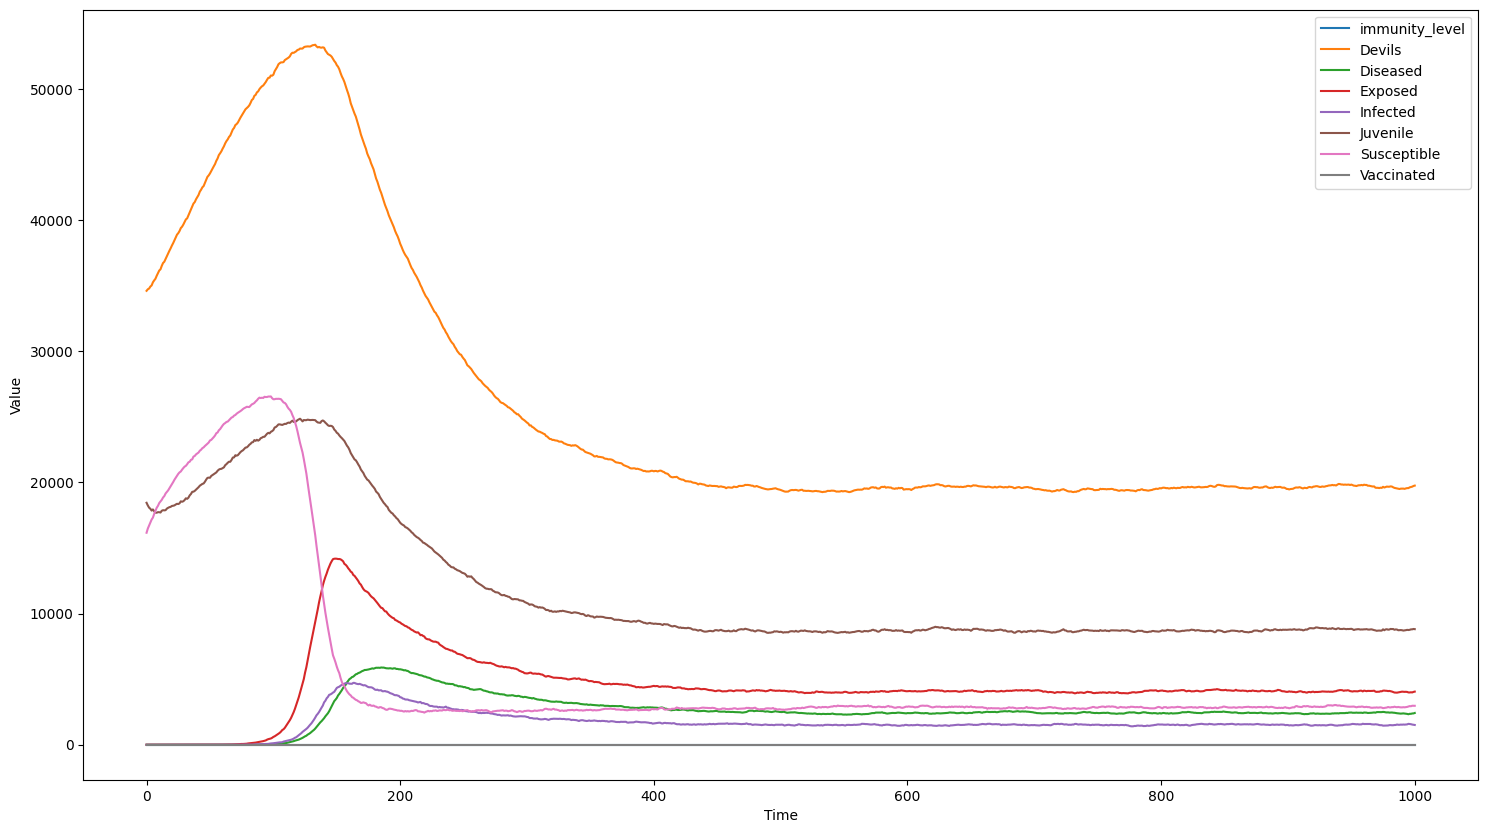

In [23]:
def configure_simulation():
    solver = TauHybridCSolver(model=None, variable=True)
    kwargs = {
        "solver": solver,
        "number_of_trajectories": 1,
        "variables" : variables
    }
    return kwargs
kwargs = configure_simulation()
%time results = model.run(**kwargs)
results.plot()

In [24]:
results.plotplotly()

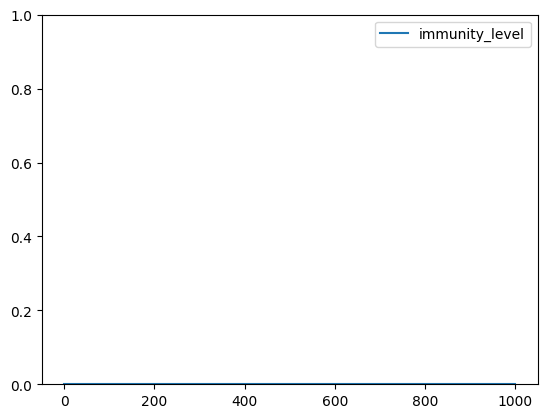

In [20]:
plt.plot(results[0]['immunity_level'], label="immunity_level")
plt.ylim(0,1)
plt.legend()